# PLOTS FOR PAPER

This notebook creates the plots for the paper. Figures are generated as PDFs in the directory cn.PLOT_DIR.

In [1]:
import pySubnetSB.constants as cn
from pySubnetSB.network import Network
from pySubnetSB.benchmark import Benchmark
from pySubnetSB.identity_hash_benchmark import IdentityHashBenchmark

import itertools
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tellurium as te
from typing import List, Optional, Union

In [2]:
PLOT_ALL = False  # Do all of the plots

In [3]:
PLOT_TITLE_FONT_INCREMENT = 2

# Data Preparation

In [4]:
FULL_STRONG_DF = pd.read_csv(cn.FULL_BIOMODELS_STRONG_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
STRONG_DF = pd.read_csv(cn.SUBNET_BIOMODELS_STRONG_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
STRONG_DF = STRONG_DF.reset_index()
FULL_WEAK_DF = pd.read_csv(cn.FULL_BIOMODELS_WEAK_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
WEAK_DF = pd.read_csv(cn.SUBNET_BIOMODELS_WEAK_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
WEAK_DF = WEAK_DF.reset_index()
SUMMARY_DF = pd.read_csv(cn.BIOMODELS_SUMMARY_PATH).sort_values(cn.D_MODEL_NAME)
SUMMARY_DF = SUMMARY_DF.reset_index()

In [5]:
STRONG_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong,truncated_strong,probability_of_occurrence_weak,trunceated_weak,estimated_poc_strong,estimated_poc_weak
0,0,BIOMD0000000006,BIOMD0000000067,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","63242: 4 species, 3 reactions\n V_Pta: AcCoA ...","{""species_names"": {""EmptySet"": ""AcCoA"", ""u"": ""...",15,False,NaN,NaN,NaN,NaN,0.0,0.0
1,1,BIOMD0000000006,BIOMD0000000715,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","2006010: 4 species, 3 reactions\n reaction_3:...","{""species_names"": {""EmptySet"": ""S"", ""u"": ""I"", ...",6,False,NaN,NaN,NaN,NaN,0.0,0.0
2,2,BIOMD0000000006,BIOMD0000000848,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","9239969: 4 species, 3 reactions\n Uninfected_...","{""species_names"": {""EmptySet"": ""T"", ""u"": ""R"", ...",18,False,NaN,NaN,NaN,NaN,0.0,0.0
3,3,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","4369297: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24,False,0.0,0.0,0.0,0.0,0.0,0.0
4,4,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","3434857: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60,False,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
WEAK_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong,truncated_strong,probability_of_occurrence_weak,truncated_weak,estimated_poc_strong,estimated_poc_weak
0,0,BIOMD0000000006,BIOMD0000000067,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","4874881: 4 species, 3 reactions\n V_Pta: AcCo...","{""species_names"": {""EmptySet"": ""AcCoA"", ""u"": ""...",15,False,NaN,NaN,NaN,NaN,0.0,0.0
1,1,BIOMD0000000006,BIOMD0000000715,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","6724008: 4 species, 3 reactions\n reaction_3:...","{""species_names"": {""EmptySet"": ""S"", ""u"": ""I"", ...",6,False,NaN,NaN,NaN,NaN,0.0,0.0
2,4,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","2240195: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24,False,NaN,NaN,NaN,NaN,0.0,0.0
3,5,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","8702568: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60,False,NaN,NaN,NaN,NaN,0.0,0.0
4,3,BIOMD0000000027,BIOMD0000000354,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","589831: 5 species, 4 reactions\n JChannel: Ca...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12,False,NaN,NaN,NaN,NaN,0.0,0.0


In [7]:
SUMMARY_DF.head

<bound method NDFrame.head of       index       model_name  num_reaction  num_species  trunceated_weak  \
0       879  BIOMD0000000001            17           12              NaN   
1       429  BIOMD0000000002            17           13              NaN   
2       914  BIOMD0000000003             7            3              0.0   
3       114  BIOMD0000000004             7            5              0.0   
4       519  BIOMD0000000005             9            9              0.0   
...     ...              ...           ...          ...              ...   
1066    510  BIOMD0000001056             5            3              0.0   
1067    660  BIOMD0000001057             5            2              0.0   
1068    380  BIOMD0000001058            20           10              NaN   
1069    431  BIOMD0000001059            21           10              NaN   
1070    663  BIOMD0000001060             7            2              0.0   

      truncated_strong  is_boundary_network  probability_

In [8]:
def makeMergeColumnName(column:str, is_reference:bool=True)->str:
    """
    Creates column names for merged result of subnet dataframe with summary dataframe.
    """
    if is_reference:
        suffix = "_reference"
    else:
        suffix = "_induced"
    return column + "_reference"

In [9]:
# Augment the subnet information with the reference num_reaction, num_species
def mergeWithSummary(subnet_df:pd.DataFrame=STRONG_DF)->pd.DataFrame:
    """
    Augment the subnet dataframe with summary information for reference network.
    """
    df = subnet_df.merge(SUMMARY_DF, right_on='model_name', left_on='reference_name',
                        suffixes=["_induced", "_reference"])
    # Clean up the DataFrame
    df = df.reset_index()
    del df['index']
    drops = df['reference_name'] == 'something'
    df = df[~drops]
    # Eliminate duplicate rows
    df['key'] = df['reference_name'] + "_" + df['target_name']  # key for an entry
    keys = list(df['key'])
    duplicate_keys = list(set([k for k in keys if keys.count(k) > 1]))
    for duplicate_key in duplicate_keys:
        duplicate_df = df [ df['key'] == duplicate_key]
        indices = list(duplicate_df.index)
        df = df.drop(indices[1:])
    # Final cleanup
    df = df.reset_index()
    return df
#
df = mergeWithSummary()
assert(len([c for c in df.columns if "_reference" in c]) > 0)
assert(len([c for c in df.columns if "_induced" in c]) > 0)
assert(len(df) <= len(STRONG_DF))
print("OK!")

OK!


In [10]:
STRONG_DF = mergeWithSummary(subnet_df=STRONG_DF)
WEAK_DF = mergeWithSummary(subnet_df=WEAK_DF)

## Check for duplicates

In [11]:
def checkSubnetDuplicates(subnet_df:pd.DataFrame, is_fix:bool=True)->pd.DataFrame:
    df = subnet_df.copy()
    keys = [r + "_" + t for r, t in zip(df[cn.FINDER_REFERENCE_NAME], df[cn.FINDER_TARGET_NAME])]
    df['key'] = keys
    count_dct = {k: keys.count(k) for k in keys}
    if len(keys) > len(set(keys)):
        for key in[k for k in set(keys) if count_dct[k] > 1]:
            if is_fix:
                sel = df['key'] == key
                idxs = df.index[sel]
                df = df.drop(idxs[:-1])
            print(key + "\n")
            print(df[df['key'] == key])
    else:
        print("No duplicates!")
    return df
        

In [12]:
print("*** WEAK")
WEAK_DF = checkSubnetDuplicates(WEAK_DF, is_fix=True)
checkSubnetDuplicates(WEAK_DF, is_fix=False)
#
print("\n***STRONG")
STRONG_DF = checkSubnetDuplicates(STRONG_DF, is_fix=True)
checkSubnetDuplicates(STRONG_DF, is_fix=False)

*** WEAK
No duplicates!
No duplicates!

***STRONG
No duplicates!
No duplicates!


,index,index_induced,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong_induced,...,index_reference,model_name,num_reaction,num_species,trunceated_weak_reference,truncated_strong_reference,is_boundary_network,probability_of_occurrence_strong_reference,probability_of_occurrence_weak_reference,key
0,0,0,BIOMD0000000006,BIOMD0000000067,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","63242: 4 species, 3 reactions\n V_Pta: AcCoA ...","{""species_names"": {""EmptySet"": ""AcCoA"", ""u"": ""...",15,False,NaN,...,805,BIOMD0000000006,3,4,0.0,0.0,False,0.00000,0.00000,BIOMD0000000006_BIOMD0000000067
1,1,1,BIOMD0000000006,BIOMD0000000715,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","2006010: 4 species, 3 reactions\n reaction_3:...","{""species_names"": {""EmptySet"": ""S"", ""u"": ""I"", ...",6,False,NaN,...,805,BIOMD0000000006,3,4,0.0,0.0,False,0.00000,0.00000,BIOMD0000000006_BIOMD0000000715
2,2,2,BIOMD0000000006,BIOMD0000000848,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","9239969: 4 species, 3 reactions\n Uninfected_...","{""species_names"": {""EmptySet"": ""T"", ""u"": ""R"", ...",18,False,NaN,...,805,BIOMD0000000006,3,4,0.0,0.0,False,0.00000,0.00000,BIOMD0000000006_BIOMD0000000848
3,3,3,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","4369297: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24,False,0.0,...,155,BIOMD0000000027,4,5,0.0,0.0,False,0.00000,0.00000,BIOMD0000000027_BIOMD0000000170
4,4,4,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","3434857: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60,False,0.0,...,155,BIOMD0000000027,4,5,0.0,0.0,False,0.00000,0.00000,BIOMD0000000027_BIOMD0000000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,1209,1207,BIOMD0000001048,BIOMD0000001059,"BIOMD0000001048: 3 species, 6 reactions\n mig...","9114784: 3 species, 6 reactions\n cleavage_of...","{""species_names"": {""Ttum"": ""pc3"", ""Tplas"": ""c3...",4,False,0.0,...,160,BIOMD0000001048,6,3,0.0,0.0,False,0.00000,0.00000,BIOMD0000001048_BIOMD0000001059
1208,1210,1208,BIOMD0000001056,BIOMD0000000294,"BIOMD0000001056: 3 species, 5 reactions\n Pro...","5701070: 3 species, 5 reactions\n r2: -> V\n...","{""species_names"": {""C1"": ""V"", ""C2"": ""S"", ""C3"":...",2,False,0.0,...,510,BIOMD0000001056,5,3,0.0,0.0,False,0.00008,0.00008,BIOMD0000001056_BIOMD0000000294
1209,1211,1209,BIOMD0000001056,BIOMD0000000810,"BIOMD0000001056: 3 species, 5 reactions\n Pro...","2698864: 3 species, 5 reactions\n growth_of_C...","{""species_names"": {""C1"": ""Cancer_Stem_Cells_S""...",9,False,0.0,...,510,BIOMD0000001056,5,3,0.0,0.0,False,0.00008,0.00008,BIOMD0000001056_BIOMD0000000810
1210,1212,1210,BIOMD0000001056,BIOMD0000000852,"BIOMD0000001056: 3 species, 5 reactions\n Pro...","9404313: 3 species, 5 reactions\n HSC_Self_Re...","{""species_names"": {""C1"": ""x0"", ""C2"": ""y0"", ""C3...",1,False,0.0,...,510,BIOMD0000001056,5,3,0.0,0.0,False,0.00008,0.00008,BIOMD0000001056_BIOMD0000000852


# Helpers

In [13]:
def makeTestDataFrame():
    df = pd.DataFrame({'reference_name': [0, 1, 1, 2, 2, 2], 'target_name': [0, 1, 1, 2, 2, 2]})
    return df.astype(str)
TEST_NUM_DUPLICATE = 5

In [14]:
def makeAntimony(model_name:str, is_reference:bool=True, subnet_df:pd.DataFrame=STRONG_DF, is_roadrunner_loadable:bool=False):
    """
    Transforms the string in a "network" cell into an antimony model
    """
    if is_reference:
        name_col = 'reference_name'
        network_col = 'reference_network'
    else:
        name_col = 'target_name'
        network_col = 'induced_network'
    models =  subnet_df[subnet_df[name_col] == model_name][network_col].values
    if len(models) == 0:
        return None
    model = models[0]
    if is_roadrunner_loadable:
        pos = model.index('tions\n')
        model = model[pos+7:]
        model = model.replace('\n', ';1\n')
        model += ";1;"
    return model

# TESTS
model = makeAntimony('BIOMD0000000224', is_roadrunner_loadable=True)
rr = te.loada(model)
model = makeAntimony('BIOMD0000000030')
assert(model is None)
print("OK!")

OK!


In [15]:
def extractBiomodelNum(stg:str)->int:
    """
    Extracts the number from the biomodels name.
    """
    substg = stg[5:]
    pos = np.min([n if c != '0' else 1000 for n, c in enumerate(substg)])
    try:
        result = int(substg[pos:])
    except:
        result = None
    return result

# TESTS
num = extractBiomodelNum('BIOMD0000000030')
assert(num == 30)
num = extractBiomodelNum('BIOMD0000002030')
assert(num == 2030)
print("OK!")

OK!


In [16]:
def checkDuplicates(df:pd.DataFrame, is_print:bool=True)->list:
    """
    Checks if elements are duplicated
    """
    keys = list(df['reference_name'] + df['target_name'])
    duplicates = []
    if len(keys) > len(set(keys)):
        duplicates = [k for k in keys if keys.count(k) > 1]
        if is_print:
            print(f"**Duplicate entries: {duplicates}")
    else:
        if is_print:
            print("**No duplicate entries")
    return duplicates

count = len(checkDuplicates(makeTestDataFrame(), is_print=False))
assert(count == TEST_NUM_DUPLICATE)
print("OK!")

OK!


In [17]:
def removeDuplicates(df:pd.DataFrame)->pd.DataFrame:
    """
    Remove rows where the reference_name + target_name is duplicated.

    Args:
        df: dataframe procesed

    Returns:
        DataFrame w/o duplicates
    """
    keys = np.array(df['reference_name'].astype(str) + df['target_name'].astype(str))
    all_positions = np.array(range(len(keys)))
    drop_idxs = []
    for key in set(keys):
        key_positions = all_positions[keys == key]
        drop_idxs.extend(key_positions[:-1])
    result_df = df.drop(drop_idxs)
    return result_df

# TESTS
df = makeTestDataFrame()
result_df = removeDuplicates(df)
assert(len(result_df) == 3)
print("OK!")   

OK!


In [18]:
def getTargetNames(reference_name:str, subnet_df:pd.DataFrame=STRONG_DF)->List[str]:
    """
    Gets the list of target names for the reference, if any.

    Args:
       reference_name: str

    Returns:
       list-str
    """
    sel = subnet_df["reference_name"] == reference_name
    if np.sum(sel) == 0:
        return None
    target_names = subnet_df[sel]["target_name"].values
    return target_names

# Tests
names = getTargetNames("BIOMD0000000224")
assert(len(names) > 0)
names = getTargetNames("BIOMD000000022x")
assert(names is None)
print("OK!")

OK!


In [19]:
def calculateLog10Probability(prob:Union[float, np.ndarray], min_prob=1e-5)->np.ndarray:
    """
    Calculates -Log10 of probabilities
    """
    if isinstance(prob, float) or isinstance(prob, int):
        new_prob = max(prob, min_prob)
    else:
        new_prob = np.array([max(v, min_prob) for v in prob])
    return -np.log10(new_prob)
        
# Test
result = calculateLog10Probability(0.4)
result = calculateLog10Probability(0)
assert(result == 5)
#
result = calculateLog10Probability([0.5, 0])
assert(result[1] == 5)
print("OK!")

OK!


# Scalable Identity Detection

In [20]:
if PLOT_ALL:
    SCALABLE_IDENTITY_DETECTION_PATH = os.path.join(cn.AUXILIARY_DATA_DIR, "scalable_identity_detection.csv")
    species_nums = range(2, 22, 2)
    reaction_nums = range(2, 22, 2)
    benchmark = IdentityHashBenchmark(species_nums, reaction_nums, num_network=1000)
    if not os.path.isfile(SCALABLE_IDENTITY_DETECTION_PATH):
        df = benchmark.plotHashStatistics(font_size=14, is_plot=False)
        df.to_csv(SCALABLE_IDENTITY_DETECTION_PATH)
    else:
        _ = benchmark.plotHashStatistics(font_size=14, hash_statistics_df=df, is_plot=False)
    path = os.path.join(cn.PLOT_DIR, "scalable_identity_detection.pdf")
    plt.savefig(path)
    plt.show()

# Scalable Subnet Discovery

## Evaluation of constraints

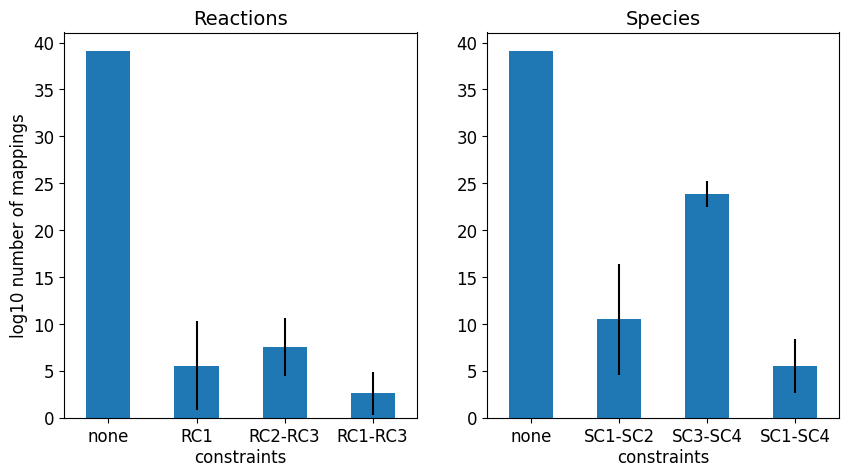

In [49]:
#if PLOT_ALL:
if True:
    reference_size = 20
    target_size = 100
    fill_size = target_size - reference_size
    benchmark = Benchmark(reference_size, fill_size=fill_size, num_iteration=1000)
    _ = benchmark.plotCompareConstraints(is_subnet=True, is_plot=False, font_size=12)
    path = os.path.join(cn.PLOT_DIR, "evaluate_constraints.pdf")
    plt.savefig(path)
    plt.show()

## Effectiveness of constraints

In [22]:
# Combine figures
if PLOT_ALL:
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(20, 10))
    gs = GridSpec(1, 32, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0:10])
    ax2 = fig.add_subplot(gs[:, 10:20])
    ax3 = fig.add_subplot(gs[:, 20:30])
    ax4 = fig.add_subplot(gs[:, 31:32])
    num_iteration = 1000
    font_size = 20
    num_digit = 0
    _ = Benchmark.plotHeatmap(range(4, 24, 4), range(10, 110, 10), percentile=50, font_size=font_size,
         ax=ax1, is_no_constraint=True, num_iteration=1, is_cbar=False, title="No constraint", is_plot=False,
        num_digit=num_digit)
    _ = Benchmark.plotHeatmap(range(4, 24, 4), range(10, 110, 10), percentile=50, is_contains_reference=True,
        font_size=font_size, num_digit=num_digit,
        ax=ax2, num_iteration=num_iteration, is_cbar=False, is_plot=False, title="constraint w/subnet")
    _ = Benchmark.plotHeatmap(range(4, 24, 4), range(10, 110, 10), percentile=50, is_contains_reference=False,
        font_size=font_size, num_digit=num_digit,
        ax=ax3, num_iteration=num_iteration, is_cbar=False, is_plot=False, title="constraint w/o subnet")
    norm = mpl.colors.Normalize(vmin=0, vmax=15)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='Reds'),
                 cax=ax4, orientation='vertical', label='log10 number of mapping pairs')
    #ax4.set_label("log10 number of assignment pairs", size=font_size)
    cbar.set_label(label='log10 number of mapping pairs',size=font_size)
    ax2.set_ylabel("")
    ax2.set_yticklabels([])
    ax3.set_ylabel("")
    ax3.set_yticklabels([])
    path = os.path.join(cn.PLOT_DIR, "scalable_subnet_discovery.pdf")
    plt.savefig(path)
    plt.show()

# Statistical significance of a network

Calculation of the POC of networks with weak and strong identity to the BioModels reference networks (those with number reactions <= 10)

In [23]:
def plotModelPOC(is_strong:bool=True, is_plot:bool=True, font_size=16):
    if is_strong:
        column = cn.D_PROBABILITY_OF_OCCURRENCE_STRONG
        adjective = 'Strong'
    else:
        column = cn.D_PROBABILITY_OF_OCCURRENCE_WEAK
        adjective = 'Weak'
    pivot_df = SUMMARY_DF.pivot_table(values=column,
                    index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES, aggfunc='median')
    pivot_df = pivot_df.map(lambda x: calculateLog10Probability(x))
    pivot_df.sort_index(level=0, ascending=False, inplace=True)
    if is_plot:
        sns.heatmap(pivot_df, annot=True, fmt="1.0f", cmap="coolwarm", vmin=0, vmax=5,
              annot_kws={'size': font_size},
              cbar_kws={'label': '-log10 Probability of occurrence'})
        #plt.title(f"{adjective} Identity")
        plt.xlabel("number of species", size=font_size)
        plt.ylabel("number of reactions", size=font_size)
        path = os.path.join(cn.PLOT_DIR, "poc_benchmark.pdf")
        plt.savefig(path)
        plt.show()
# Test
plotModelPOC(is_strong=True, is_plot=False)
print("OK!")

OK!


In [24]:
#if PLOT_ALL:
if True:
    #plotModelPOC(is_strong=True)
    # Little difference between strong and weak identity
    #plt.figure()
    #plotModelPOC(is_strong=False)
    sizes = list(itertools.product(range(2, 11), range(2, 11)))
    done = False
    if os.path.isfile("benchmark.csv"):
        df = pd.read_csv("benchmark.csv")
        if len(df) == len(sizes):
            done = True
    if not done:
        df = Benchmark.calculateOccurrence(sizes, identity=cn.ID_STRONG,
           num_iteration=10000, num_replication=10)
        df.to_csv("benchmark.csv", index=False)
    Benchmark.plotSpeciesReactionHeatmap(df, cn.D_MEAN_PROBABILITY, font_size=14, 
          cbar_title="-log10 fraction identical", is_plot=False)
    path = os.path.join(cn.PLOT_DIR, "poc_random_benchmark.pdf")
    plt.savefig(path)
    plt.show()

# Subnet Discovery in BioModels

In [25]:
def heatmapCount(induced_df, title:str="", is_plot:bool=True, is_count:bool=True, ax=None,
        network_column=cn.FINDER_REFERENCE_NAME, vmax:int=-1, fmt="", font_size=8):
    """
    Counts occurrences of reference networks in induced_df or the number of induced networks.
    Args:
        is_count (bool): count distinct values of network_count; if False, calculate ratio of all occurrences to distinct
    """
    # Calculate count of networks
    count_df = induced_df.copy()
    count_df = count_df[[network_column, cn.D_NUM_SPECIES, cn.D_NUM_REACTION]]
    count_df = count_df.drop_duplicates()
    #
    if is_count:
        # Count sizes of reference networks
        plot_df = count_df
        bar_label = 'count'
        if len(fmt) == 0:
            fmt="1.0f"
        if vmax < 0:
            vmax = 10
    else:
        # Count occurrence of induced networks
        plot_df = induced_df
        bar_label = 'ratio'
        if len(fmt) == 0:
            fmt="1.1f"
        if vmax < 0:
            vmax = 100
    network_ser = count_df.groupby([cn.D_NUM_SPECIES, cn.D_NUM_REACTION]).count()[network_column]
    induced_ser = induced_df.groupby([cn.D_NUM_SPECIES, cn.D_NUM_REACTION]).count()[network_column]
    if is_count:
        plot_ser = network_ser
    else:
        plot_ser = induced_ser/network_ser
    num_species = [x[0] for x in network_ser.index]
    num_reactions = [x[1] for x in network_ser.index]
    df = pd.DataFrame({cn.D_NUM_SPECIES: num_species, cn.D_NUM_REACTION: num_reactions, 'count': plot_ser.values})
    pivot_df = df.pivot_table(values='count', index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES)
    pivot_df.sort_index(level=0, ascending=False, inplace=True)
    if is_plot:
        if ax is None:
            _, ax = plt.subplots(1)
        _ = sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="coolwarm", vmin=0, vmax=vmax,
              annot_kws={'size': font_size}, ax=ax,
              cbar_kws={'label': bar_label})
        ax.figure.axes[-1].yaxis.label.set_size(font_size)
        cbar_ticklabels = ax.figure.axes[-1].get_yticklabels()
        ax.figure.axes[-1].set_yticklabels(cbar_ticklabels, size=font_size)
        ax.set_title(title, size=font_size+PLOT_TITLE_FONT_INCREMENT)
        ax.set_xlabel("number of species", size=font_size)
        ax.set_ylabel("number of reactions", size=font_size)
        xticklabels = ax.get_xticklabels()
        ax.set_xticklabels(xticklabels, size=font_size)
        yticklabels = ax.get_yticklabels()
        ax.set_yticklabels(yticklabels, size=font_size)
# Test
heatmapCount(STRONG_DF, title="", is_plot=False, is_count=True, font_size=14)
print("OK!")

OK!


## Reference networks that induce networks

In [26]:
if False:
    title = "Sizes of Inducing Reference Networks"
    title = ""
    heatmapCount(STRONG_DF, title=title, is_plot=True, network_column=cn.FINDER_REFERENCE_NETWORK,
                 is_count=True, font_size=14)
    path = os.path.join(cn.PLOT_DIR, "all_reference_network_count.pdf")
    plt.savefig(path)

In [27]:
constrained_strong_df = STRONG_DF.copy()
# Remove small reference networks
sel = [s > 3 and r > 3 for s, r in zip(constrained_strong_df[cn.D_NUM_SPECIES], constrained_strong_df[cn.D_NUM_REACTION])]
CONSTRAINED_STRONG_DF = constrained_strong_df[sel]

In [28]:
if False:
    title = "Reference Size"
    title = ""
    heatmapCount(CONSTRAINED_STRONG_DF, title=title, is_plot=True, network_column=cn.FINDER_REFERENCE_NETWORK,
                 is_count=True, font_size=14)
    path = os.path.join(cn.PLOT_DIR, "filtered_reference_network_count.pdf")
    plt.savefig(path)

In [29]:
if False:
    title = "Induced Networks per Reference Network By Reference Size"
    title = ""
    heatmapCount(CONSTRAINED_STRONG_DF, title=title,
                 network_column=cn.FINDER_REFERENCE_NETWORK,
                 is_count=False, vmax=10, font_size=14,
                 is_plot=True)
    path = os.path.join(cn.PLOT_DIR, "filtered_induced_network_reference.pdf")
    plt.savefig(path)

In [30]:
if PLOT_ALL:
    _, axes = plt.subplots(1, 2, figsize=(20, 10))
    font_size = 20
    title = "count of reference networks"
    heatmapCount(STRONG_DF, title=title, is_plot=True, network_column=cn.FINDER_REFERENCE_NETWORK,
                 is_count=True, font_size=font_size, ax=axes[0])
    title = "induced network per reference network"
    heatmapCount(STRONG_DF, title=title,
                 network_column=cn.FINDER_REFERENCE_NETWORK,
                 is_count=False, vmax=10, font_size=font_size, ax=axes[1],
                 is_plot=True)
    path = os.path.join(cn.PLOT_DIR, "biomodels_results.pdf")
    plt.savefig(path)

In [31]:
print(f"Number of distinct strong reference models: {len(set(STRONG_DF[cn.FINDER_REFERENCE_NAME]))}")
print(f"Number of distinct weak reference models: {len(set(WEAK_DF[cn.FINDER_REFERENCE_NAME]))}")
print(f"Number of distinct strong reference models processed: {len(set(FULL_STRONG_DF[cn.FINDER_REFERENCE_NAME]))}")
print(f"Number of distinct weak reference models processed: {len(set(FULL_WEAK_DF[cn.FINDER_REFERENCE_NAME]))}")
print(f"Number of distinct strong target models: {len(set(STRONG_DF[cn.FINDER_TARGET_NAME]))}")
print(f"Number of distinct weak target models processed: {len(set(FULL_WEAK_DF[cn.FINDER_TARGET_NAME]))}")
print(f"Number of distinct strong target models processed: {len(set(FULL_STRONG_DF[cn.FINDER_TARGET_NAME]))}")
print(f"Number of distinct weak target models: {len(set(WEAK_DF[cn.FINDER_TARGET_NAME]))}")
print(f"Number of strong pairs evaluated: {len(FULL_STRONG_DF)}")
print(f"Number of weak pairs evaluated: {len(FULL_WEAK_DF)}")
print(f"Number of strong induced subnsets: {len(STRONG_DF)}")
print(f"Number of weak induced subnsets: {len(WEAK_DF)}")

Number of distinct strong reference models: 83
Number of distinct weak reference models: 93
Number of distinct strong reference models processed: 224
Number of distinct weak reference models processed: 223
Number of distinct strong target models: 274
Number of distinct weak target models processed: 489
Number of distinct strong target models processed: 489
Number of distinct weak target models: 328
Number of strong pairs evaluated: 109536
Number of weak pairs evaluated: 94030
Number of strong induced subnsets: 1212
Number of weak induced subnsets: 1338


In [32]:
if False:
    heatmapPOC(STRONG_DF, 'probability_of_occurrence_strong_induced', title="Strong, Induced, POC", is_plot=True)
    plt.figure()
    heatmapPOC(WEAK_DF, 'probability_of_occurrence_strong_induced', title="Weak, Induced, POC", is_plot=True)

## Target networks with induced networks

In [33]:
strong_df = CONSTRAINED_STRONG_DF[[cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME]]
strong_df = strong_df.merge(SUMMARY_DF, right_on='model_name', left_on='target_name')
strong_df = strong_df[[cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME, cn.D_NUM_REACTION, cn.D_NUM_SPECIES]]

In [34]:
if False:
    title = "Target Sizes"
    title = ""
    heatmapCount(strong_df, title=title, is_plot=True, network_column=cn.FINDER_TARGET_NAME,
                 is_count=True, vmax=5)
    path = os.path.join(cn.PLOT_DIR, "target_network_count.pdf")
    plt.savefig(path)

In [35]:
if False:
    title = "Induced Networks per Target Network By Target Size"
    title = ""
    heatmapCount(strong_df, title=title, network_column=cn.FINDER_TARGET_NAME,
                 is_count=False, vmax=5, fmt="1.0f",
                 is_plot=True)
    path = os.path.join(cn.PLOT_DIR, "induced_network_target.pdf")
    plt.savefig(path)

In [36]:
## Weak vs. Strong

In [37]:
len(STRONG_DF), len(WEAK_DF)

(1212, 1338)

# Target with most subnets

In [38]:
targets = list(STRONG_DF[cn.FINDER_TARGET_NAME].values)
targets = [int(n[-5:-1]) for n in targets]
target_dct = {n: targets.count(n) for n in set(targets)}

In [39]:
max(STRONG_DF[cn.FINDER_TARGET_NAME].values)

'BIOMD0000001059'

In [40]:
{t: t for t in target_dct.keys() if  target_dct[t] == 57}

{85: 85}

In [41]:
sel = STRONG_DF[cn.FINDER_TARGET_NAME] == "BIOMD0000001059"
STRONG_DF[sel]

,index,index_induced,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong_induced,...,index_reference,model_name,num_reaction,num_species,trunceated_weak_reference,truncated_strong_reference,is_boundary_network,probability_of_occurrence_strong_reference,probability_of_occurrence_weak_reference,key
236,238,236,BIOMD0000000156,BIOMD0000001059,"BIOMD0000000156: 3 species, 5 reactions\n R1:...","4814365: 3 species, 5 reactions\n Production_...","{""species_names"": {""x"": ""iap"", ""y"": ""c3"", ""y0""...",8,False,0.0,...,908,BIOMD0000000156,5,3,0.0,0.0,False,0.00008,0.00009,BIOMD0000000156_BIOMD0000001059
604,606,604,BIOMD0000000546,BIOMD0000001059,"BIOMD0000000546: 3 species, 5 reactions\n re1...","9209917: 3 species, 5 reactions\n cleavage_of...","{""species_names"": {""s1"": ""pc3"", ""s2"": ""c3"", ""s...",8,False,0.0,...,358,BIOMD0000000546,5,3,0.0,0.0,False,0.00007,0.00007,BIOMD0000000546_BIOMD0000001059
705,707,705,BIOMD0000000789,BIOMD0000001059,"BIOMD0000000789: 4 species, 5 reactions\n vir...","3028684: 4 species, 5 reactions\n Production_...","{""species_names"": {""V"": ""iap"", ""S"": ""pc3"", ""I""...",56,False,0.0,...,909,BIOMD0000000789,5,4,0.0,0.0,False,0.00000,0.00000,BIOMD0000000789_BIOMD0000001059
1076,1078,1076,BIOMD0000001012,BIOMD0000001059,"BIOMD0000001012: 4 species, 7 reactions\n CAR...","4139213: 4 species, 7 reactions\n Production_...","{""species_names"": {""CAR_T_cells"": ""iap"", ""Leuk...",20,False,0.0,...,863,BIOMD0000001012,7,4,0.0,0.0,False,0.00000,0.00000,BIOMD0000001012_BIOMD0000001059
1207,1209,1207,BIOMD0000001048,BIOMD0000001059,"BIOMD0000001048: 3 species, 6 reactions\n mig...","9114784: 3 species, 6 reactions\n cleavage_of...","{""species_names"": {""Ttum"": ""pc3"", ""Tplas"": ""c3...",4,False,0.0,...,160,BIOMD0000001048,6,3,0.0,0.0,False,0.00000,0.00000,BIOMD0000001048_BIOMD0000001059


# Reference network details

In [42]:
def findTargets(reference_biomodel:str)->pd.DataFrame:
    """
    Prints the targets reference model
    """
    ref_df = WEAK_DF
    sel = ref_df[cn.FINDER_REFERENCE_NAME] == reference_biomodel
    df = ref_df[sel][[cn.FINDER_TARGET_NAME, cn.FINDER_INDUCED_NETWORK]]
    df = df.reset_index()
    del df['index']
    return df

# Tests
df = findTargets("BIOMD0000000027")
print(df.loc[1, cn.FINDER_INDUCED_NETWORK])

8702568: 5 species, 4 reactions
  pRB_phosphorylation: pRB -> pRBp
  pRBp_phosphorylation: pRBp -> pRBpp
  pRBpp_dephosphorylation: pRBpp -> pRBp
  pRBp_dephosphorylation: pRBp -> pRB


In [43]:
findTargets("BIOMD0000000519")["target_name"]

0    BIOMD0000000289
1    BIOMD0000000290
2    BIOMD0000000539
3    BIOMD0000000687
4    BIOMD0000000848
5    BIOMD0000000852
6    BIOMD0000001059
Name: target_name, dtype: object

In [44]:
sel = FULL_WEAK_DF[cn.FINDER_TARGET_NAME] == "BIOMD0000000146"
sel2 = np.logical_and(FULL_WEAK_DF[sel]['num_assignment_pair'].notna(), sel)
np.sum(sel2)

0

In [45]:
# Print all of the reference models that appear in targets
names = list(set(CONSTRAINED_STRONG_DF[cn.FINDER_REFERENCE_NAME]))
names = list(set(WEAK_DF[cn.FINDER_REFERENCE_NAME]))
#names = list(set(STRONG_DF[cn.FINDER_REFERENCE_NAME]))
names.sort()
print(f"Number of distinct networks: {len(names)}\n")
for name in names:
    result = makeAntimony(name)
    if result is not None:
        print(result + '\n\n')

Number of distinct networks: 93

BIOMD0000000006: 4 species, 3 reactions
  Reaction1: EmptySet -> z
  Reaction2: u -> EmptySet
  Reaction3: z -> u


BIOMD0000000027: 5 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000031: 6 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000047: 2 species, 3 reactions
  Jch: CaER -> Ca_Cyt
  Jleak: CaER -> Ca_Cyt
  Jpump: Ca_Cyt -> CaER


BIOMD0000000060: 4 species, 3 reactions
  Closed_state_1: Po1 -> Pc1
  Open_state_2: Po1 -> Po2
  Closed_State_2: Po1 -> Pc2


BIOMD0000000076: 3 species, 2 reactions
  Gpd_p: DHAP -> G3P
  Gpp_p: G3P -> Gly


BIOMD0000000104: 6 species, 2 reactions
  reaction_0: species_0 -> species_1
  reaction_1: species_1 -> species_4


BIOMD0000000114: 2 species, 4 reactions
  reaction_0000001:  -> y
  reaction_0000002: x -> y
  reaction_0000003: y -> 
  reaction_0000004: x -> y


BIOMD0000000115: 2 species, 5 reactions
  reaction_0000001:  

# Scalability analysis

In [73]:
idx = 0
df.loc[idx, 1]/df.loc[idx, :]

1    1.000000
2    1.305085
4    2.026316
8    2.264706
Name: 0, dtype: float64

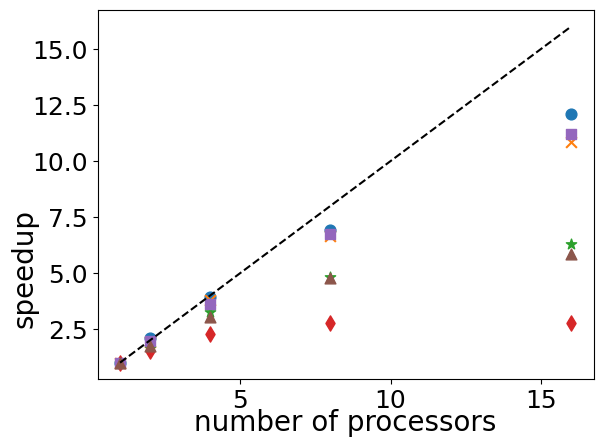

In [132]:
# Data from scalability runs. reference size: 5; target size: 100, max_num_assignment: 1e11. max_batch_size: 1e4
# The following was done on the Macbook M1
data_arr = np.array([
[77, 59, 38, 34],
[1363, 1133, 889, 794],
[295, 157, 84, 48],
    [383, 187, 101, 57],
])
# The following was done on Mac Studio M1
data_arr = np.array([
    [7951, 3824, 2021, 1149, 658],
[564, 291, 149, 85, 52],
[82, 49, 25, 17, 13],
[77, 50, 34, 28, 28],
[818, 416, 227, 121, 73],
[240, 138, 79, 50, 41]
])
#
FONTSIZE = 18
markers = ['o', 'x', '*', 'd', 's', '^']
df = pd.DataFrame(data_arr, columns=[1, 2, 4, 8, 16])
for idx in df.index:
    ser = df.loc[idx, 1]/df.loc[idx, :]
    plt.scatter(df.columns, ser, marker=markers[idx], s=60)
plt.plot([1,16], [1,16], linestyle="--", color='black')
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.tick_params(axis='y', labelsize=FONTSIZE)
plt.xlabel("number of processors", fontsize=FONTSIZE + 2)
_ = plt.ylabel("speedup", fontsize=FONTSIZE + 2)
ax = plt.gca()
ax.xaxis.set_label_coords(0.5, -0.08, transform=ax.transAxes)
ax.yaxis.set_label_coords(-0.12, 0.3, transform=ax.transAxes)
path = os.path.join(cn.PLOT_DIR, "speedup.pdf")
plt.savefig(path)

In [91]:
df

,1,2,4,8,16
0,7951,3824,2021,1149,658
1,564,291,149,85,52
2,82,49,25,17,13
3,77,50,34,28,28
4,818,416,227,121,73
5,240,138,79,50,41
